# Livrable 3 : Captioning

|Auteur|Centre|Modification|
|---|---|---|
|Emilien Pons|Toulouse|2021/01/15|
|Nicolas Hurtevent|Toulouse|2021/01/15|
|Pierre Mazurier|Toulouse|2021/01/15|
|Pacome Chu-Lejeune|Toulouse|2021/01/15|

![logoEI_1_6.jpg](https://arras.cesi.fr/wp-content/uploads/sites/9/2019/05/Cesi_Logo_INGENIEUR_RVB-HD-500x296.jpg)

## Introduction

L'entreprise TouNum, travaillant sur la numérisation de documents, nous demande de réaliser une solution d'image captioning. L'architecture de la solution est composée de plusieurs modules, comme décrit sur le schéma suivant.

[SCHEMA]

L'architecture de la solution d'image-captionning est composée de 4 modules : un module de chargement d'image, un module déterminant si l'image est une photo ou non, un troisième module de traitement basique d'image pour la rendre plus éxploitable et un dernier module de captionning.

Dans ce document, {insérer logique ici}

Ce modèle sera utilisé par la suite sur la solution de captionning finale.

A noter que l'ensemble du code proposé est basé du Workshop CESI ainsi que le [tutoriel](https://www.tensorflow.org/tutorials/text/image_captioning?hl=fr) TensorFlow sur le sous-titrage d'images.

# PLAN

- Mise en place de TensorFlow
- Architecture globale de la solution
- Petit descriptif sur le pré-traitements de image et du texte
- Fonctions et dataset
    - Initialisation du notebook
    - Préparation des datasets
- Mise en place CNN
    - Explications
    - Implémentation
- Passage dans le RNN
    - Explications
    - Implémentation
    - Suivi de l'évolution des perf pendant l'entrainement sous forme de courbes
- Résultats
- Conclusion

## Mise en place de tensorflow

Si ce n'est pas déjà fait dans le livrable précèdent et que vous souhaitez tester le code, il est nécessaire d'utiliser TensorFlow. C'est un outil d'apprentissage automatique développé par Google et l'un des outils les plus utilisés en IA dans le domaine du Machine Learning. Il nous offre une bibliothèque riche qui nous permettra de créer éfficacement des réseaux de neuronnes de toute architecture. C'est également l'outil que nous avons pu prendre en main lors de nos précèdents workshops.

![logo_TS](https://www.tensorflow.org/images/tf_logo_social.png)

## Architecture globale de la solution

Expliquer en gros ce que l'on va faire dans ce document avec un joli schéma

## Petit descriptif sur le pré-traitements d' image et du texte

Partie de maz ici

## Fonctions et dataset

Expliquez les bibliothèques

In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

Explication dataset Coco

In [3]:
annotation_folder = "/annotations/"
annotation_file = os.path.abspath('.')+"/annotations/captions_train2014.json"

image_folder = '/train2014/'
PATH = os.path.abspath('.') + image_folder

print("annotation file ", annotation_file)
print("le chemin PATH ", PATH)

annotation file  C:\Users\Emilien\Documents\Data Science\Livrable 3\Projet-data-science-livrable-3/annotations/captions_train2014.json
le chemin PATH  C:\Users\Emilien\Documents\Data Science\Livrable 3\Projet-data-science-livrable-3/train2014/


### 35000 images au lieu des 82000

In [4]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaque annotation
    caption = f"<start> {val['caption']} <end>"
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

In [5]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
train_image_paths = image_paths[:2000]
print(len(train_image_paths))

2000


### Vérification

In [6]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> a banana cut in half on a white plate  <end>


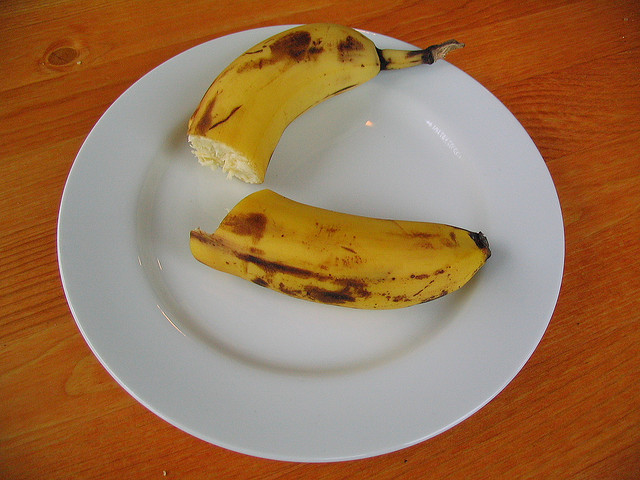

In [8]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Mise en place CNN

### Prétraiter les images avec inceptionV3

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))# 299px/299px
    img = tf.keras.applications.inception_v3.preprocess_input(img) #normalisation
    return img, image_path

### Initialisez InceptionV3 et chargez les poids Imagenet pré-entraînés

In [12]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet') #poids de imageNet
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

#On créer un le nouveau modèle
image_features_extract_model = tf.keras.Model(new_input, hidden_layer) 


### Mise en cache

In [17]:
#Barre de progression pour la mise en cache

!pip install -q tqdm

In [18]:
from tqdm import tqdm

# Prendre les noms des images et qu'elles soient uniques
encode_train = sorted(set(img_name_vector))

# On CHANGE LA TAILLE DES BATCHS ICI ==> 16
# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuez le pré-traitement d'InceptionV3
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

100%|██████████| 125/125 [02:27<00:00,  1.18s/it]


### Prétraitez et jeter les sous-tîtres 

In [26]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

- Tout d'abord, vous allez tokeniser les légendes (par exemple, en les fractionnant sur des espaces). Cela nous donne un vocabulaire de tous les mots uniques dans les données (par exemple, «surf», «football», etc.).
- Ensuite, vous allez limiter la taille du vocabulaire aux 5 000 premiers mots (pour économiser de la mémoire). Vous remplacerez tous les autres mots par le jeton "UNK" (inconnu).

In [27]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)


In [28]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


- Vous créez ensuite des mappages mot-à-index et index-mot.

In [22]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)


- Enfin, vous remplissez toutes les séquences pour qu'elles aient la même longueur que la plus longue.

In [23]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


In [24]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)


## Divisez les données en formation et en test

In [29]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [30]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)


(8003, 8003, 2000, 2000)

## Créer un ensemble de données tf.data pour l'entraînement

Nos images et légendes sont prêtes! Ensuite, créons un ensemble de données tf.data à utiliser pour entraîner notre modèle.

In [32]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64


In [33]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [34]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### Modèle de notre décodeur

In [35]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [36]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [37]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [38]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [39]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


### Point de contrôle 

In [40]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [41]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)


## Configuration entraînement

     Vous extrayez les fonctionnalités stockées dans les fichiers .npy respectifs, puis passez ces fonctionnalités via l'encodeur.
    La sortie du codeur, l'état caché (initialisé à 0) et l'entrée du décodeur (qui est le jeton de démarrage) sont transmis au décodeur.
    Le décodeur renvoie les prédictions et l'état caché du décodeur.
    L'état caché du décodeur est ensuite renvoyé dans le modèle et les prédictions sont utilisées pour calculer la perte.
    Utilisez le forçage de l'enseignant pour décider de la prochaine entrée du décodeur.
    Le forçage par l'enseignant est la technique par laquelle le mot cible est transmis comme entrée suivante au décodeur.
    La dernière étape consiste à calculer les dégradés et à l'appliquer à l'optimiseur et à la rétropropagation.

In [42]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []


In [43]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

## Entrainement (prend du temps)

In [44]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 2.0000
Epoch 1 Batch 100 Loss 1.0915
Epoch 1 Loss 1.242602
Time taken for 1 epoch 389.26143503189087 sec

Epoch 2 Batch 0 Loss 1.1368
Epoch 2 Batch 100 Loss 0.9086
Epoch 2 Loss 0.990753
Time taken for 1 epoch 227.14224100112915 sec

Epoch 3 Batch 0 Loss 0.8714
Epoch 3 Batch 100 Loss 0.8300
Epoch 3 Loss 0.854427
Time taken for 1 epoch 248.88802456855774 sec

Epoch 4 Batch 0 Loss 0.8149
Epoch 4 Batch 100 Loss 0.7170
Epoch 4 Loss 0.771082
Time taken for 1 epoch 332.5689260959625 sec

Epoch 5 Batch 0 Loss 0.7152
Epoch 5 Batch 100 Loss 0.6388
Epoch 5 Loss 0.707565
Time taken for 1 epoch 262.13286566734314 sec

Epoch 6 Batch 0 Loss 0.6531
Epoch 6 Batch 100 Loss 0.5960
Epoch 6 Loss 0.656553
Time taken for 1 epoch 289.6168496608734 sec

Epoch 7 Batch 0 Loss 0.6566
Epoch 7 Batch 100 Loss 0.5976
Epoch 7 Loss 0.612996
Time taken for 1 epoch 378.06139945983887 sec

Epoch 8 Batch 0 Loss 0.5870
Epoch 8 Batch 100 Loss 0.5468
Epoch 8 Loss 0.574283
Time taken for 1 epoch 242.959053

##Epoch 1 Batch 0 Loss 2.0000
Epoch 1 Batch 100 Loss 1.0915
Epoch 1 Loss 1.242602
Time taken for 1 epoch 389.26143503189087 sec

Epoch 2 Batch 0 Loss 1.1368
Epoch 2 Batch 100 Loss 0.9086
Epoch 2 Loss 0.990753
Time taken for 1 epoch 227.14224100112915 sec

Epoch 3 Batch 0 Loss 0.8714
Epoch 3 Batch 100 Loss 0.8300
Epoch 3 Loss 0.854427
Time taken for 1 epoch 248.88802456855774 sec

Epoch 4 Batch 0 Loss 0.8149
Epoch 4 Batch 100 Loss 0.7170
Epoch 4 Loss 0.771082
Time taken for 1 epoch 332.5689260959625 sec

Epoch 5 Batch 0 Loss 0.7152
Epoch 5 Batch 100 Loss 0.6388
Epoch 5 Loss 0.707565
Time taken for 1 epoch 262.13286566734314 sec

Epoch 6 Batch 0 Loss 0.6531
Epoch 6 Batch 100 Loss 0.5960
Epoch 6 Loss 0.656553
Time taken for 1 epoch 289.6168496608734 sec

Epoch 7 Batch 0 Loss 0.6566
Epoch 7 Batch 100 Loss 0.5976
Epoch 7 Loss 0.612996
Time taken for 1 epoch 378.06139945983887 sec

Epoch 8 Batch 0 Loss 0.5870
Epoch 8 Batch 100 Loss 0.5468
Epoch 8 Loss 0.574283
Time taken for 1 epoch 242.95905303955078 sec

Epoch 9 Batch 0 Loss 0.5809
Epoch 9 Batch 100 Loss 0.5504
Epoch 9 Loss 0.540751
Time taken for 1 epoch 255.77163743972778 sec

Epoch 10 Batch 0 Loss 0.5313
Epoch 10 Batch 100 Loss 0.4527
Epoch 10 Loss 0.507140
Time taken for 1 epoch 290.4181168079376 sec

Epoch 11 Batch 0 Loss 0.4661
Epoch 11 Batch 100 Loss 0.4345
Epoch 11 Loss 0.474795
Time taken for 1 epoch 247.2590527534485 sec

Epoch 12 Batch 0 Loss 0.4844
Epoch 12 Batch 100 Loss 0.4725
Epoch 12 Loss 0.448073
Time taken for 1 epoch 307.0858852863312 sec

Epoch 13 Batch 0 Loss 0.4377
Epoch 13 Batch 100 Loss 0.4160
Epoch 13 Loss 0.423161
Time taken for 1 epoch 362.19678950309753 sec

Epoch 14 Batch 0 Loss 0.4163
Epoch 14 Batch 100 Loss 0.3759
Epoch 14 Loss 0.407230
Time taken for 1 epoch 253.18747782707214 sec

Epoch 15 Batch 0 Loss 0.3705
Epoch 15 Batch 100 Loss 0.3840
Epoch 15 Loss 0.382341
Time taken for 1 epoch 329.2177879810333 sec

Epoch 16 Batch 0 Loss 0.3580
Epoch 16 Batch 100 Loss 0.3513
Epoch 16 Loss 0.359277
Time taken for 1 epoch 374.02978706359863 sec

Epoch 17 Batch 0 Loss 0.3510
Epoch 17 Batch 100 Loss 0.3868
Epoch 17 Loss 0.336313
Time taken for 1 epoch 291.92990708351135 sec

Epoch 18 Batch 0 Loss 0.3095
Epoch 18 Batch 100 Loss 0.3189
Epoch 18 Loss 0.316383
Time taken for 1 epoch 294.9158880710602 sec

Epoch 19 Batch 0 Loss 0.3172
Epoch 19 Batch 100 Loss 0.2968
Epoch 19 Loss 0.299328
Time taken for 1 epoch 346.1478910446167 sec

Epoch 20 Batch 0 Loss 0.2902
Epoch 20 Batch 100 Loss 0.2756
Epoch 20 Loss 0.288604
Time taken for 1 epoch 309.39293003082275 sec



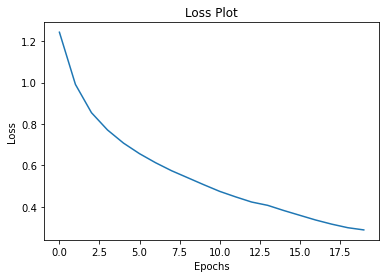

In [48]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Légende!

In [52]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [53]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


Real Caption: <start> the boys ride skate boards and do graffiti on the wall <end>
Prediction Caption: there is a skateboard <end>


ValueError: num must be 1 <= num <= 4, not 5

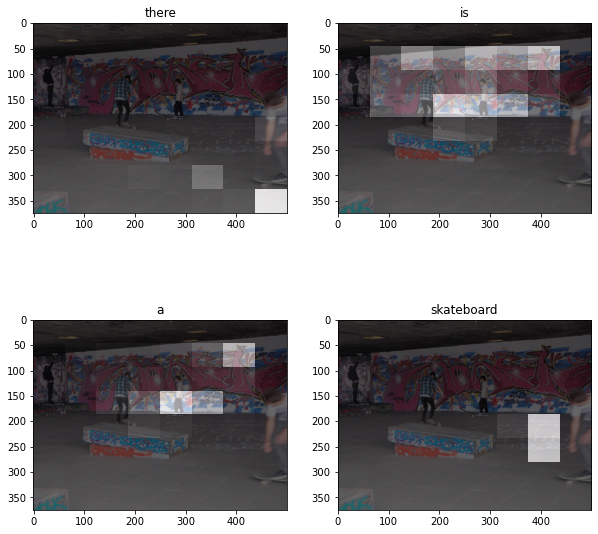

In [51]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


## Essayez-le sur vos propres images

65536/64400 [==============================] - 0s 3us/step
Prediction Caption: a young man riding on water wave in the water <end>


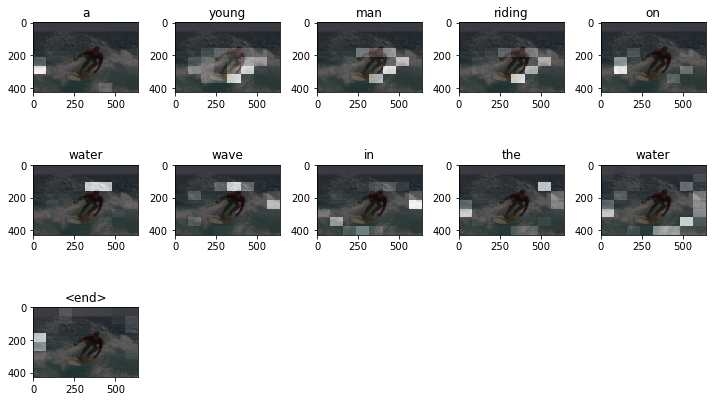

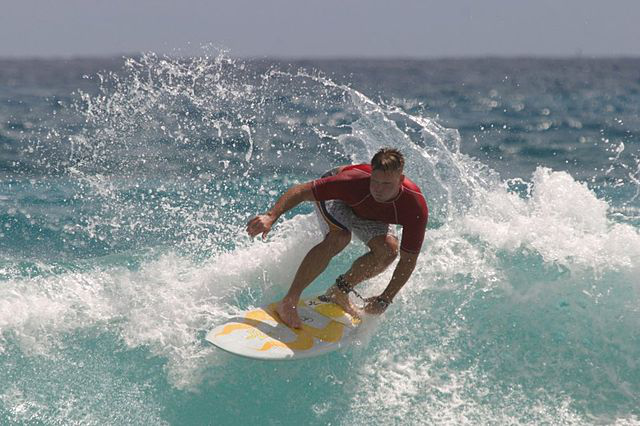

In [54]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)


## Conclusion